# <center> 数据挖掘大作业：宇宙飞船泰坦尼克号 </center>

**import** 导入在过程当中可能会使用到的python包

In [2]:
# Core
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
# from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
# import lazypredict
# from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')
print('Done')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Done


## 数据

**加载数据**

In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv') # 训练集
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')   # 测试集

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**功能描述：**
- **PassengerId** - 每位乘客的唯一ID。每个ID的形式为gggg_pp，其中gggg表示乘客所在的组，pp表示该组中的编号。一个组中的人通常是家人，但不总是。
- **HomePlanet** - 乘客出发的星球，通常是他们的常驻星球。
- **CryoSleep** - 表示乘客是否选择在航行期间进入悬浮动画状态。处于悬浮动画状态的乘客被限制在自己的舱室内。
- **Cabin** - 乘客所居住的舱室号码。形式为deck/num/side，其中side可以是P（舷侧）或S（舷侧）。
- **Destination** - 乘客将要下船的星球。
- **Age** - 乘客的年龄。
- **VIP** - 乘客是否支付了豪华VIP服务费。
- **RoomService**，**FoodCourt**，**ShoppingMall**，**Spa**，**VRDeck** - 乘客在太空游轮“泰坦尼克号”上的许多奢华设施上的消费金额。
- **Name** - 乘客的名字和姓氏。
- **Transported** - 乘客是否被传送到另一个维度。这是目标，你要预测的列。


In [4]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


查看每一行数据中出现缺失值的数量

In [5]:
print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


检查数据集中有没有重复数据

In [6]:
print(f'\033[94m')
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print('')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')


Duplicates in train set: 0, (0.0%)

Duplicates in test set: 0, (0.0%)


有上面可以看到数据集不错，里面是没有重复值出现的，但是缺失值确实不少，我们先来看看数据集中的特征，最后是需要对于缺失值进行处理的

In [7]:
train.nunique() # 训练集唯一值

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

In [8]:
train.dtypes # 训练集数据类型

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

在进行完数据处理之后需要将非数值型的数据转化成为数值型的数据，以便于模型的处理

## 探索性数据分析

分析目标的分布规律

Text(0.5, 1.0, 'Target_distribution')

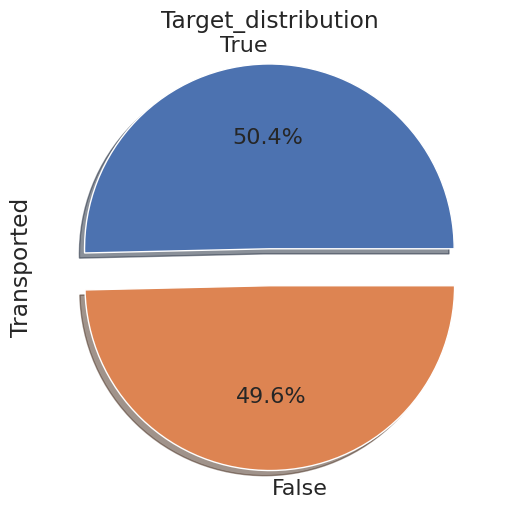

In [9]:
plt.figure(figsize=(6,6))

# Pie plot
train['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target_distribution")

由上面的我们可以看到分布基本是对半分的，所以这个数据集是比较均衡的

**连续性特征**

Text(0.5, 0, 'Age (years)')

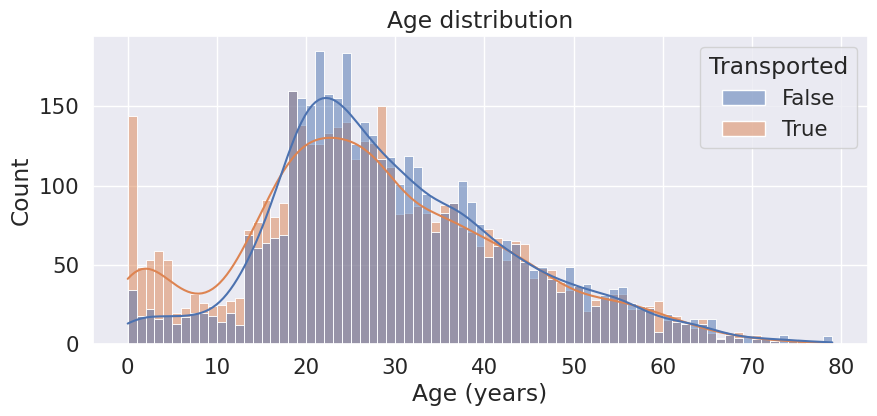

In [10]:
# Figure size
plt.figure(figsize=(10,4))

# 查看传送成功和不成功的样本的年龄分布
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True) # kde:核密度估计

plt.title('Age distribution')
plt.xlabel('Age (years)')

从中可以得到下面的结论：
+ 0-18岁的乘客中，传送成功的比例更高
+ 18-25岁的乘客中，传送成功的比例更低
+ 25岁以上的乘客中，传送成功的和不成功的比例基本相同

这给到我们一个启示可以按照三个年龄段对于数据进行划分，这样可以更好的进行模型的训练

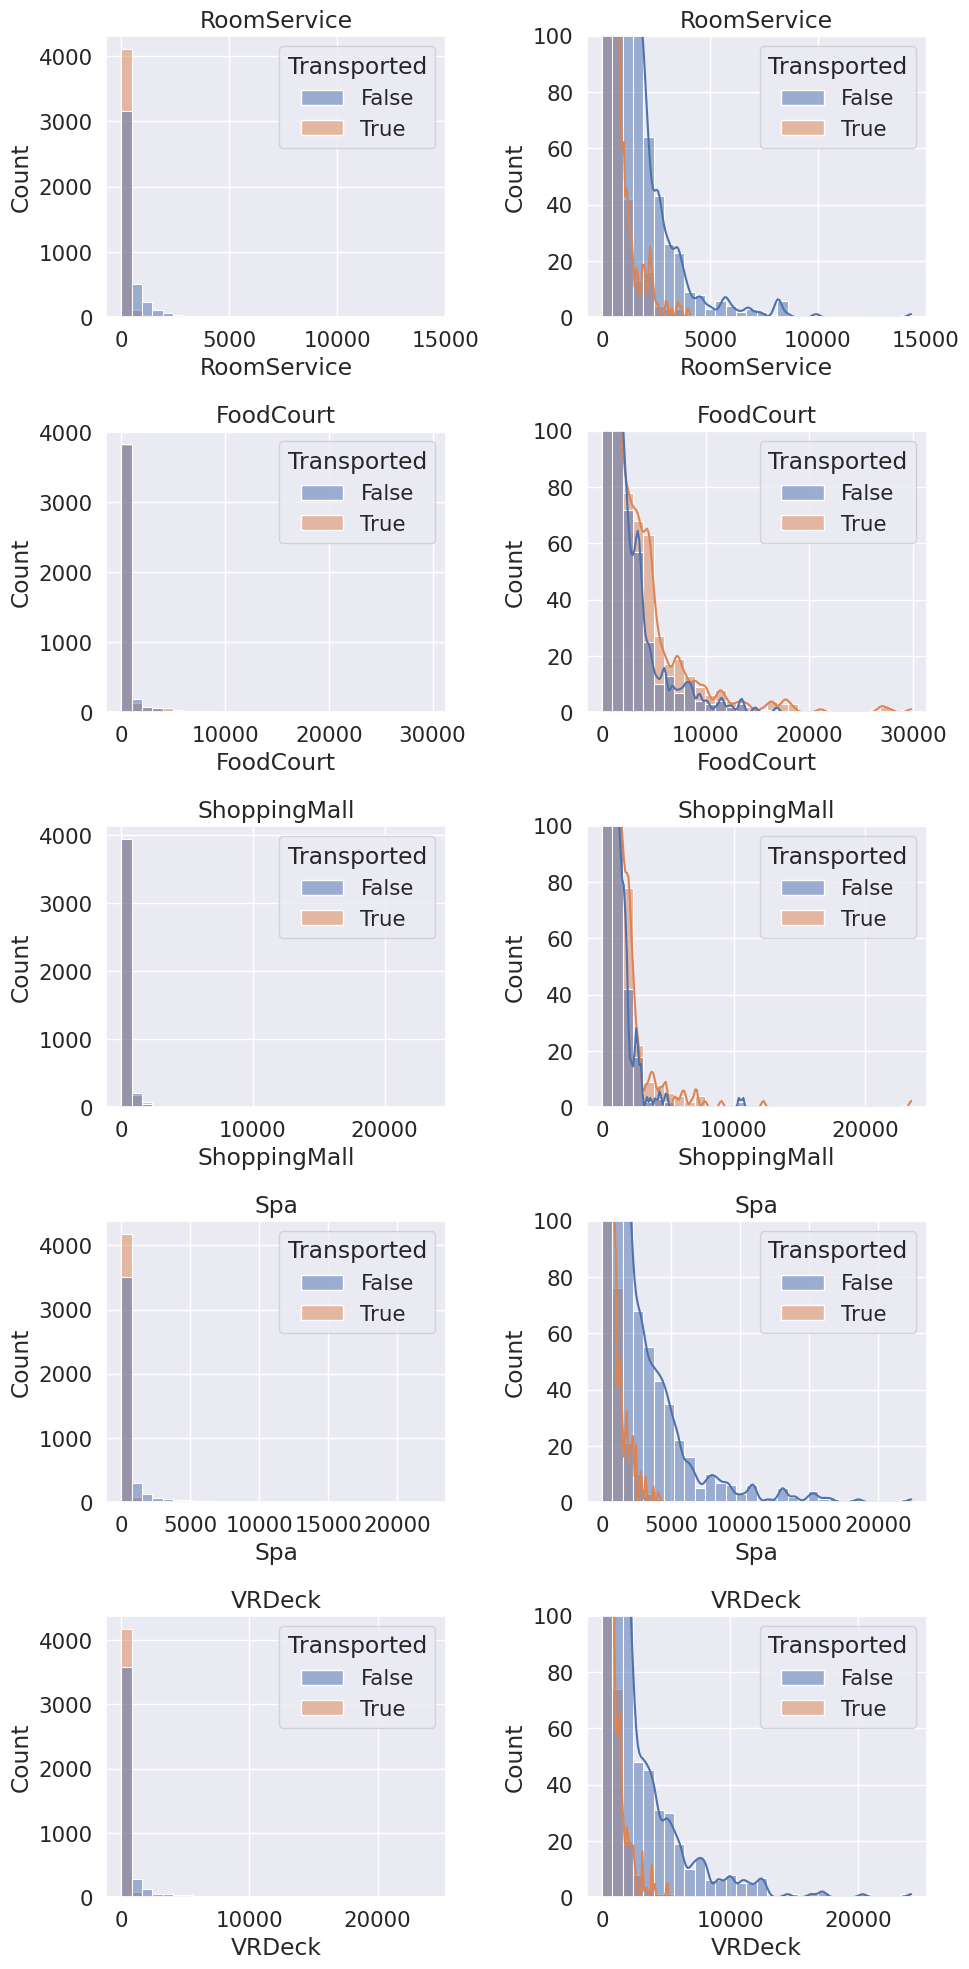

In [11]:
# Expenditure features 花费特征
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

从中我们可以得到下面的结论：
+ 大多数的人没有花多少钱
+ 花费的分布呈指数衰减（如右图所示）
+ 存在一小部分异常值
+ 被传送的人倾向于花费较少
+ RoomService（客房服务）、Spa（温泉）和VRDeck（虚拟现实甲板）与FoodCourt（美食广场）和ShoppingMall（购物中心）有不同的分布 - 我们可以将其视为奢侈品与基本设施。

这些在数据处理当中可以给我们下面的启示：
+ 创建一个新的特征，跟踪所有5个设施的总支出。
+ 创建一个二进制特征，用于指示该人是否没有花费任何金额（即总支出为0）。
+ 进行对数转换以减小偏度。

**类别特征**

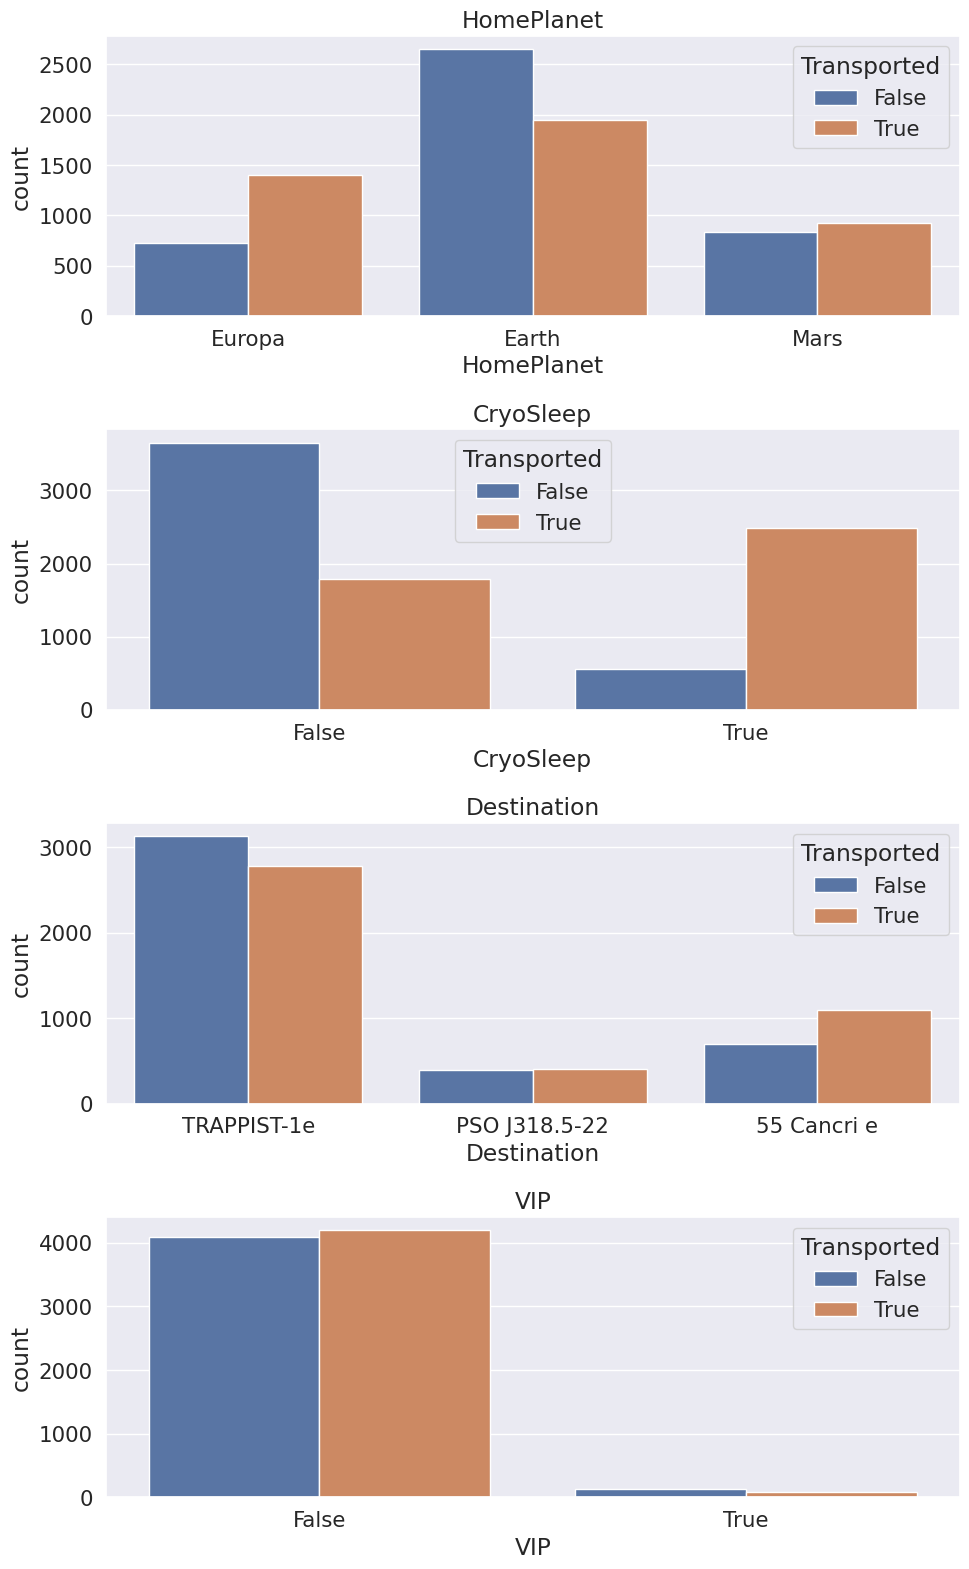

In [12]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

从中我们可以得到下面的结论：
+ VIP这个信息由于在传送成功和不成功的乘客里面基本都是对半分布，因此这个特征对于我们的模型训练没有什么帮助，所以我们可以将其删除
+ CryoSleep很重要，因为在传送成功的乘客中，大多数都是在冷冻睡眠中醒来的

这些在数据处理当中可以给我们下面的启示：
+ 可以将VIP特征删除

**定性特征**

In [13]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name'] # 客舱号，姓名
# qual_feats 意思是 qualitative features

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


*从中我们可以获取下面的信息：*
* PassengerId的形式为gggg_pp，其中gggg表示乘客所在的组，pp表示该组中的编号。
* Cabin的形式为deck/num/side，其中side可以是P表示舷侧（Port），或者是S表示舷侧（Starboard）。

*其中我们可以得到的启示：*
* 我们可以从PassengerId特征中提取组别和组内人数。
* 我们可以从Cabin特征中提取甲板（deck）、编号（number）和舷侧（side）。
* 我们可以从姓名（Name）特征中提取姓氏以识别家庭。


## 特征工程

根据数据探索中获得的方向对于数据进行处理

**年龄**
根据上面的启示，可以看到可以对于年龄的分布进行分组，这样可以更好的在建模的时候利用传送成功率在不同的年龄段的分布

Text(0.5, 1.0, 'Age group distribution')

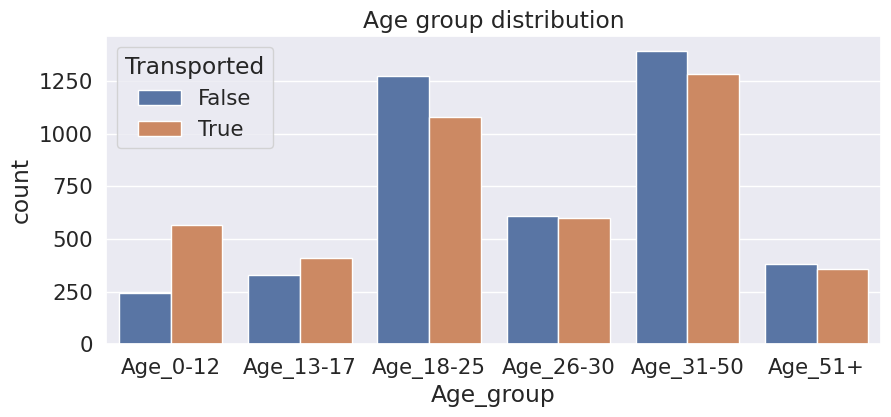

In [14]:
# New features - training set
train['Age_group']=np.nan
train.loc[train['Age']<=12,'Age_group']='Age_0-12'
train.loc[(train['Age']>12) & (train['Age']<18),'Age_group']='Age_13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25),'Age_group']='Age_18-25'
train.loc[(train['Age']>25) & (train['Age']<=30),'Age_group']='Age_26-30'
train.loc[(train['Age']>30) & (train['Age']<=50),'Age_group']='Age_31-50'
train.loc[train['Age']>50,'Age_group']='Age_51+'

# New features - test set
test['Age_group']=np.nan
test.loc[test['Age']<=12,'Age_group']='Age_0-12'
test.loc[(test['Age']>12) & (test['Age']<18),'Age_group']='Age_13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25),'Age_group']='Age_18-25'
test.loc[(test['Age']>25) & (test['Age']<=30),'Age_group']='Age_26-30'
test.loc[(test['Age']>30) & (test['Age']<=50),'Age_group']='Age_31-50'
test.loc[test['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

不同组内的传送的成功率有差距，基本符合我们之前数据探索当中得出的结论

**消费**

计算总的消费并去定位哪些没有消费的乘客

(0.0, 20000.0)

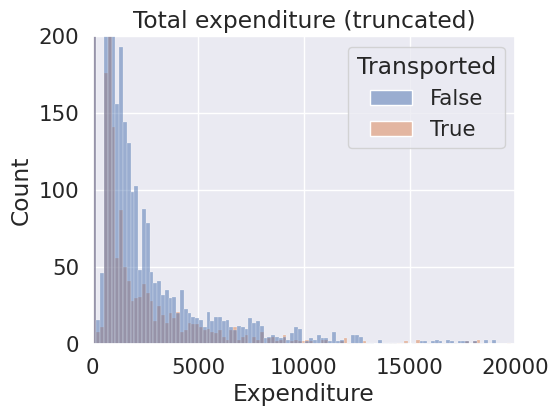

In [15]:
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])


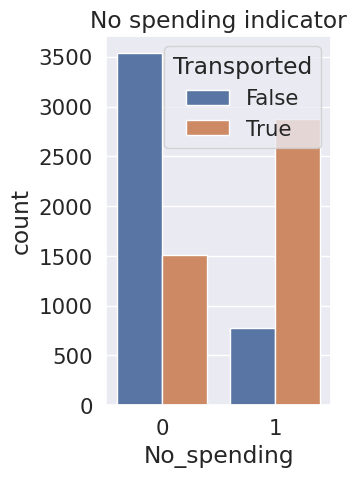

In [16]:
plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

其中可以看到消费为0的乘客中，传送成功的比例要高于传送失败的比例，这个特征可以作为一个特征

**乘客的分组**

从乘客的PassengerId中提取出乘客的组别和组内人数

下面的这个比较大回头拿服务器跑一下，我的电脑有点跑不动了

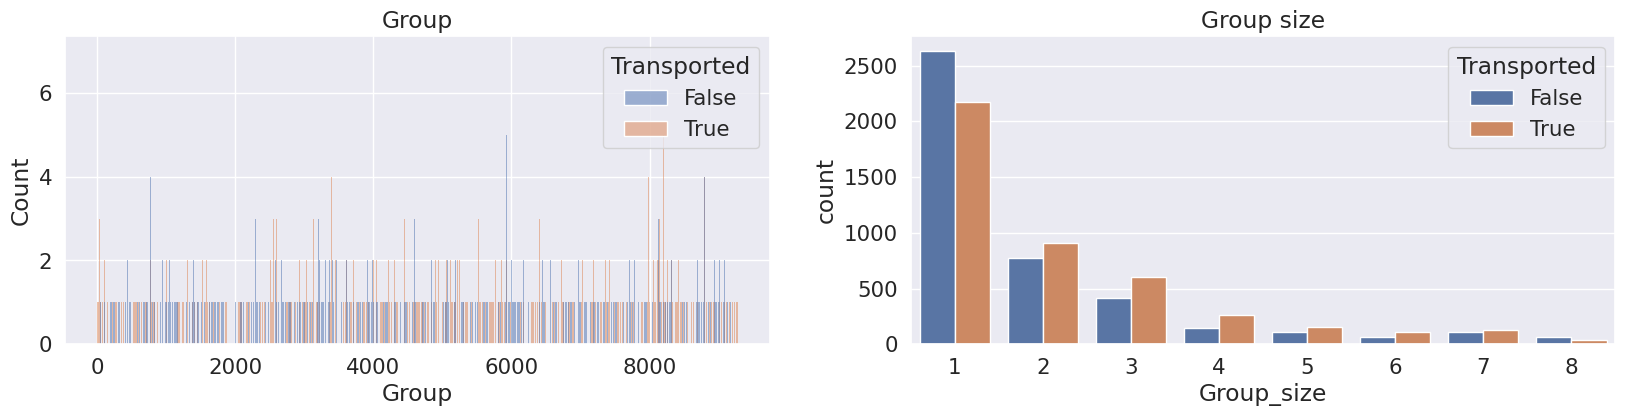

In [17]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['Group_size']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

我们无法在模型中真正使用“Group”特征，因为它的基数太大（6217），使用独热编码会导致维度爆炸。

另一方面，组大小应该是一个有用的特征。实际上，我们可以通过创建一个“Solo”列进一步压缩该特征，以跟踪某人是否独自旅行。右侧的图表显示，与组大小大于1相比，组大小为1的人更不太可能被传送。

**定位甲板信息**

从舱位特征中提取出甲板信息

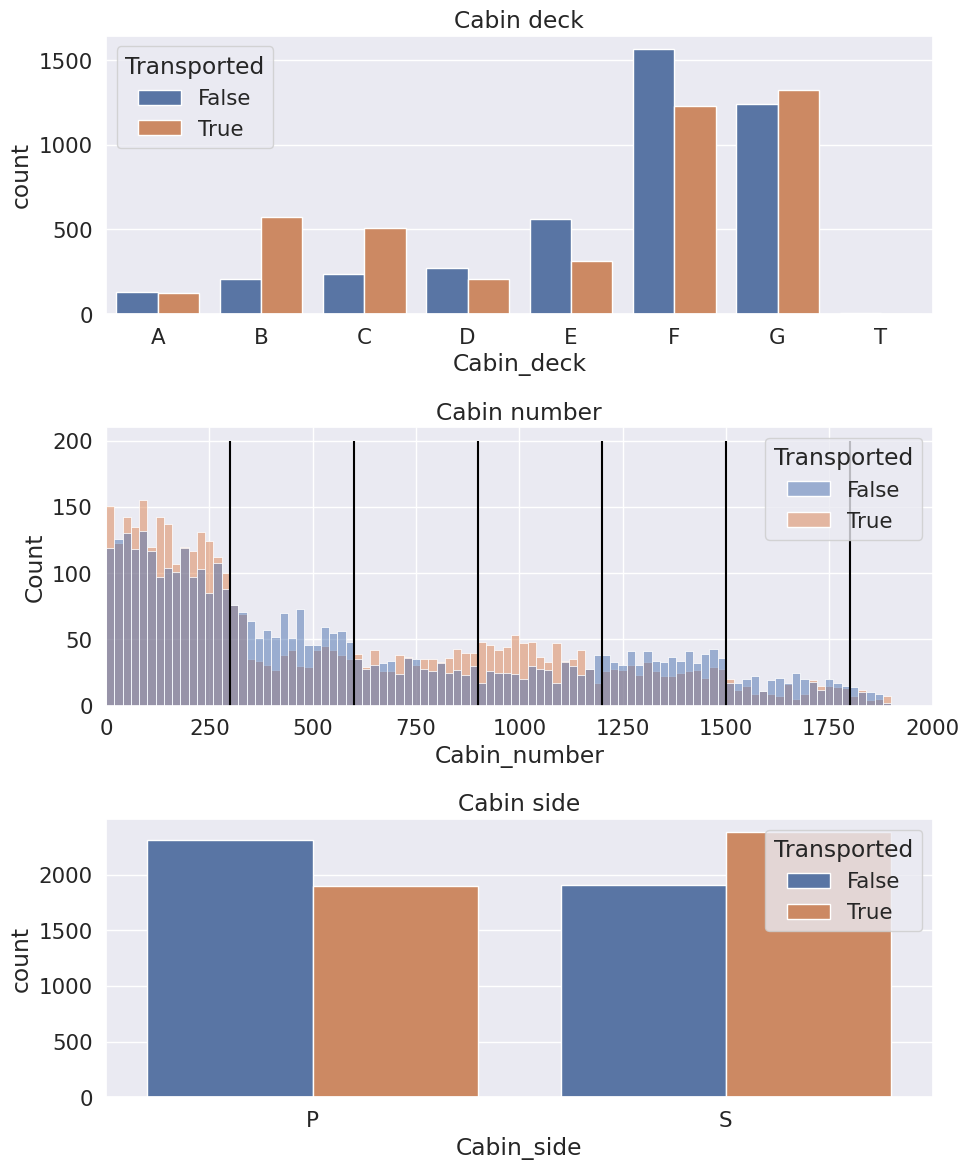

In [18]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

这个甲板特征里面的T又可能是个异常值，太少了，只有5个

看起来Cabin_number被分组成了每组300个舱室。这意味着我们可以将这个特征压缩成一个分类特征，指示每位乘客所在的舱室组

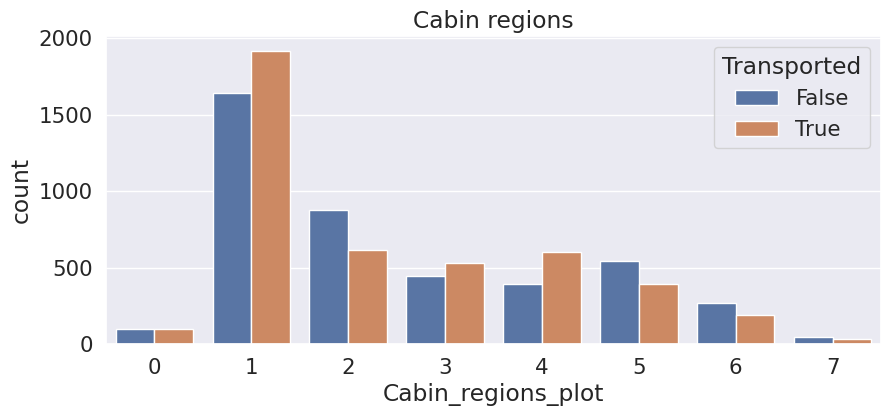

In [19]:
# New features - training set
train['Cabin_region1']=(train['Cabin_number']<300).astype(int)   # one-hot encoding
train['Cabin_region2']=((train['Cabin_number']>=300) & (train['Cabin_number']<600)).astype(int)
train['Cabin_region3']=((train['Cabin_number']>=600) & (train['Cabin_number']<900)).astype(int)
train['Cabin_region4']=((train['Cabin_number']>=900) & (train['Cabin_number']<1200)).astype(int)
train['Cabin_region5']=((train['Cabin_number']>=1200) & (train['Cabin_number']<1500)).astype(int)
train['Cabin_region6']=((train['Cabin_number']>=1500) & (train['Cabin_number']<1800)).astype(int)
train['Cabin_region7']=(train['Cabin_number']>=1800).astype(int)

# New features - test set
test['Cabin_region1']=(test['Cabin_number']<300).astype(int)   # one-hot encoding
test['Cabin_region2']=((test['Cabin_number']>=300) & (test['Cabin_number']<600)).astype(int)
test['Cabin_region3']=((test['Cabin_number']>=600) & (test['Cabin_number']<900)).astype(int)
test['Cabin_region4']=((test['Cabin_number']>=900) & (test['Cabin_number']<1200)).astype(int)
test['Cabin_region5']=((test['Cabin_number']>=1200) & (test['Cabin_number']<1500)).astype(int)
test['Cabin_region6']=((test['Cabin_number']>=1500) & (test['Cabin_number']<1800)).astype(int)
test['Cabin_region7']=(test['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['Cabin_region1']+2*train['Cabin_region2']+3*train['Cabin_region3']+4*train['Cabin_region4']+5*train['Cabin_region5']+6*train['Cabin_region6']+7*train['Cabin_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

**姓**

可以根据其中姓的个数去计算这个家庭一共有多少人

Text(0.5, 1.0, 'Family size')

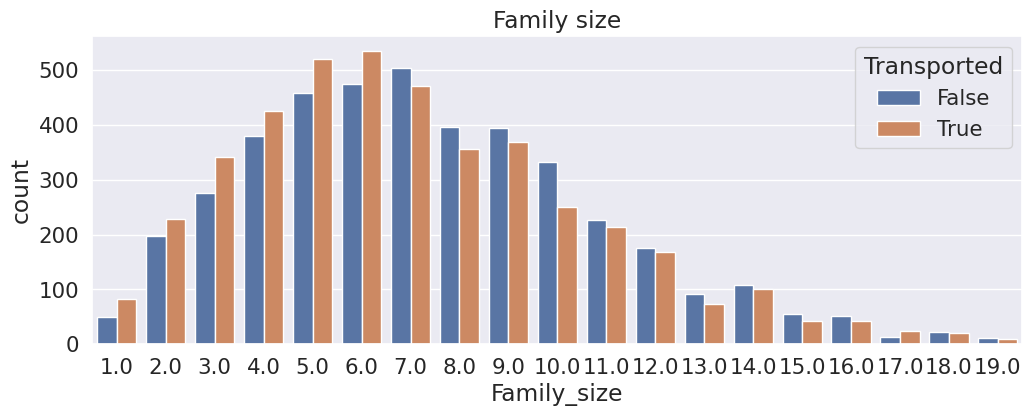

In [20]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]

# New feature - Family size
train['Family_size']=train['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])
test['Family_size']=test['Surname'].map(lambda x: pd.concat([train['Surname'],test['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train.loc[train['Surname']=='Unknown','Surname']=np.nan
train.loc[train['Family_size']>100,'Family_size']=np.nan
test.loc[test['Surname']=='Unknown','Surname']=np.nan
test.loc[test['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Family_size', hue='Transported')
plt.title('Family size')

上面作图反映了不同人数家庭的个数

## 处理缺失值

合并训练集和测试集来处理缺失值，两个放在一起处理缺失值更有利于从总体上把握特征，能够更好的处理缺失值。
当然在完成缺失值处理之后还是要将训练集和测试集分开的 

In [21]:
# Labels and features
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test], axis=0).reset_index(drop=True)

**探索缺失值**

In [22]:
# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['缺失量'])
mv['缺失比例']=np.round(100*mv['缺失量']/len(data),2)
mv

,缺失量,缺失比例
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


画个热力图来看看缺失值的分布

Text(0.5, 1.0, 'Heatmap of missing values')

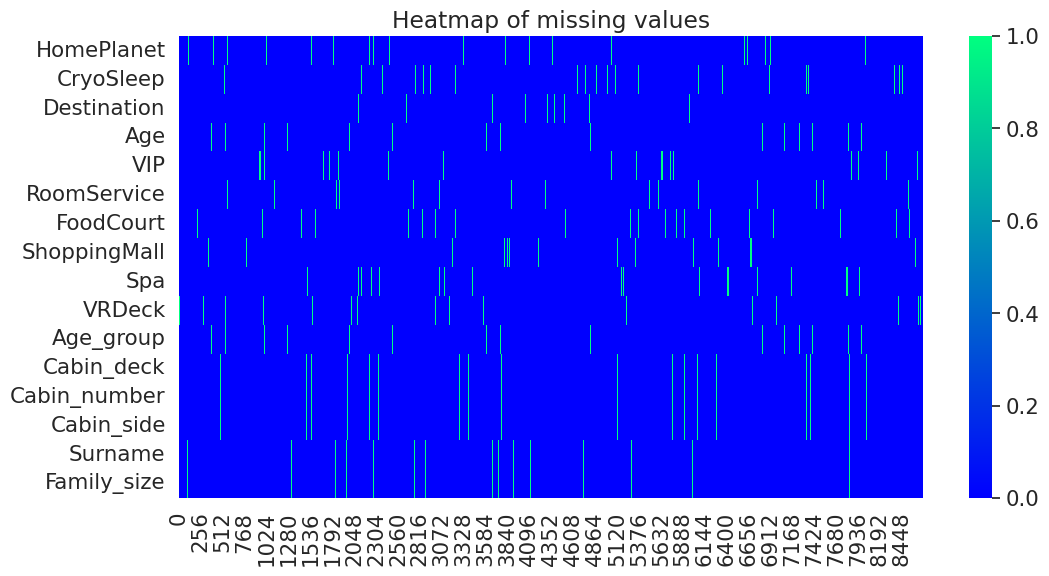

In [23]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='winter')
plt.title('Heatmap of missing values')

从总体上看来缺失值占比大概在2%-3%，这个比例不算大

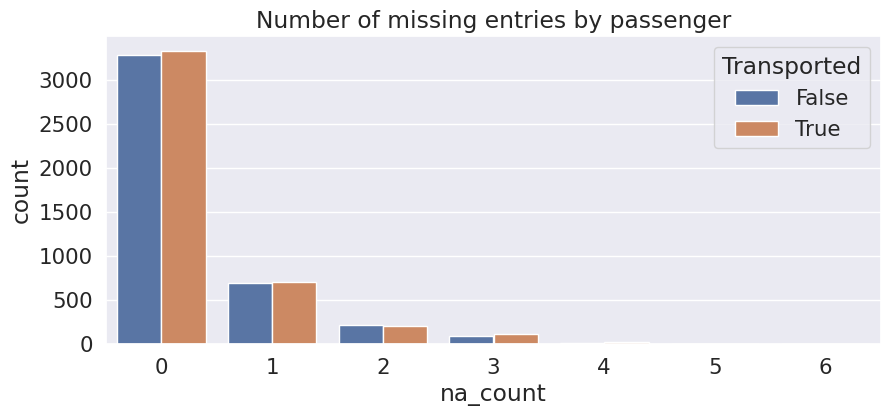

In [24]:
# 统计每个数值缺失的比例
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

可以看到大部分的数据缺失启示都是缺1个数据，有极少数的情况出现了缺了2-3个数据的，但是好在没有缺了更多的数据的

*上面的内容给到的提示*
* 缺失值与目标变量独立，大部分情况下是孤立存在的。
* 尽管数据中只有2%的缺失值，但大约25%的乘客至少有一个缺失值。
* PassengerId是唯一一个没有任何缺失值的（原始）特征。

*从上面的内容中得到的启发*
* 由于大部分缺失值是孤立存在的，与其删除行，填充这些缺失值是有意义的。
* 如果PassengerId与其他特征之间存在关联，我们可以根据该列填充缺失值。


处理缺失值的最简单方法是对连续特征使用中位数，对分类特征使用众数（请参阅本笔记本的第20个版本）。这种方法足够有效，但如果我们想要最大化模型的准确性，我们需要寻找缺失数据中的模式。要做到这一点，可以观察特征的联合分布，例如，同一组的乘客是否倾向于来自同一家庭？显然存在许多组合，因此我们将总结我和其他人发现的有用趋势。

**来自的星球和分组之间的关系**

In [25]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0) # unstack:将分组后的数据转换为矩阵
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


In [26]:
# 统计每组Number of unique home planets per group
GHP_gb['n_unique']=GHP_gb.apply(lambda x: sum(x>0), axis=1) # axis=1:按行统计
GHP_gb.head()

HomePlanet,Earth,Europa,Mars,n_unique
Group,,,,
1,0.0,1.0,0.0,1
2,1.0,0.0,0.0,1
3,0.0,2.0,0.0,1
4,1.0,0.0,0.0,1
5,1.0,0.0,0.0,1


In [27]:
# 输出星球数量大于1的组的个数
print(f'\033[94mNumber of groups with more than 1 unique home planet: {sum(GHP_gb["n_unique"]>1)}')

Number of groups with more than 1 unique home planet: 0


由此可见几乎每组的乘客都来自一个相同的星球，那么我们可以按照组别来补充其中来自星球的信息

In [28]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


这就意味着有131个缺失值我们是可以以100%确定把这些缺失值填充上去的

**母星和仓位所在的甲板**

画个热力图看看各个甲板上来自各个星球的人数的分布

<AxesSubplot: xlabel='Cabin_deck', ylabel='HomePlanet'>

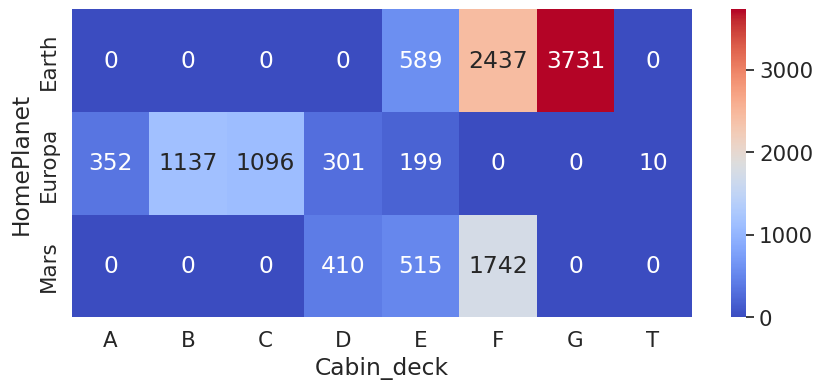

In [29]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

* 来自欧罗巴的乘客在 A、B、C 或 T 层甲板上。
* 来自地球的乘客在 G 层甲板上。
* 来自多个行星的乘客在 D、E 或 F 层甲板上。

利用这样的一个规律我们可以将A,B,C,T,G甲板上母星缺失的给填补上

In [30]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


**母星和姓**

设想同一个姓的又可能是同一个家庭的，而同一个家庭注定会来自同一个星球，为了验证猜想先来做图看看

Text(0.5, 1.0, 'Number of unique planets per surname')

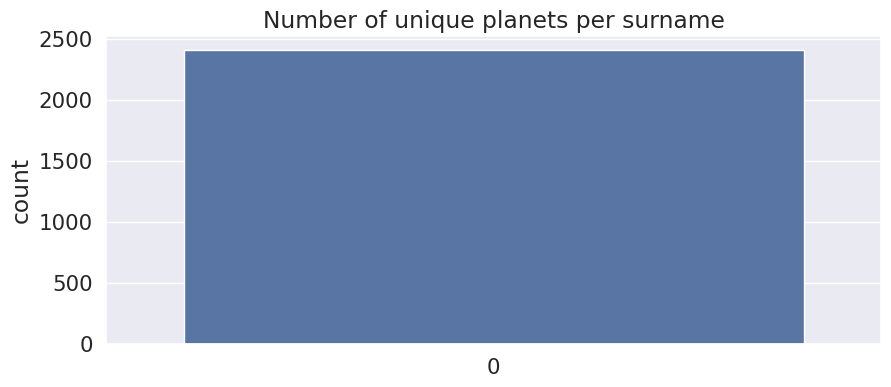

In [31]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

In [32]:
# Joint distribution of Surname and HomePlanet
SHP_gb = data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

#展示分组后的数据
SHP_gb.head()

HomePlanet,Earth,Europa,Mars
Surname,,,
Acobson,5.0,0.0,0.0
Acobsond,8.0,0.0,0.0
Adavisons,10.0,0.0,0.0
Adkinson,4.0,0.0,0.0
Admingried,0.0,4.0,0.0


Text(0, 0.5, 'Number of surnames')

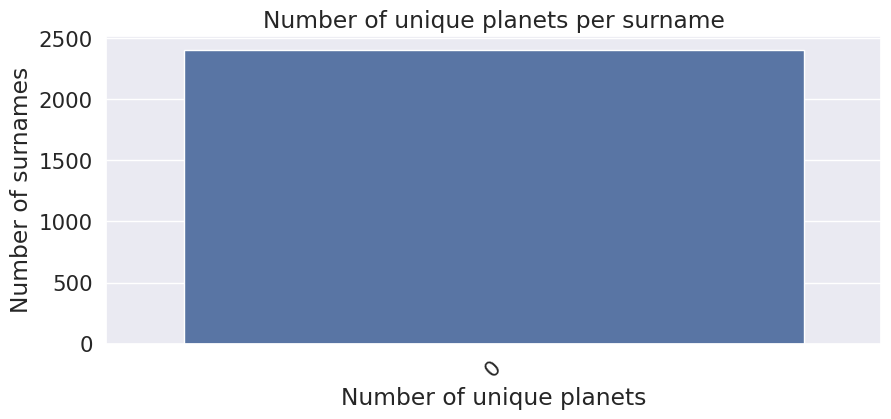

In [33]:
# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb >= 1).sum(axis=1))
plt.title('Number of unique planets per surname')

# 设置横坐标轴上的数值和标签
plt.xticks(rotation=45)
plt.xlabel('Number of unique planets')
plt.ylabel('Number of surnames')

In [34]:
# 输出一个有多个星球的姓氏的个数
print('Number of surnames with more than one planet:',((SHP_gb>0).sum(axis=1)>1).sum())

Number of surnames with more than one planet: 0


综合上面信息可以得知同一个姓氏的都来自同一个星球，因此，我们可以利用姓氏对于来自的星球进行填充

In [35]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


现在来自星球数据缺失就只有10个了！

既然只有10个那么我们不妨来看看剩下的是什么

In [36]:
# 查看还没有被处理的10个数据
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


In [37]:
# 查看还没有被处理的10个数据
data[data['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
2274,2443_01,NaN,False,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,0.0,...,P,1,0,0,0,0,0,0,NaN,NaN
2631,2817_01,NaN,False,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,0.0,...,P,0,1,0,0,0,0,0,Sutty,1.0
3091,3331_01,NaN,False,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,0.0,...,S,0,0,1,0,0,0,0,NaN,NaN
4548,4840_01,NaN,True,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,0.0,...,S,0,0,0,1,0,0,0,NaN,NaN
5762,6108_01,NaN,False,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,1.0,...,S,0,0,0,1,0,0,0,NaN,NaN
8969,0616_01,NaN,False,TRAPPIST-1e,31.0,False,0.0,428.0,NaN,1154.0,...,S,1,0,0,0,0,0,0,Spriney,1.0
10583,4052_01,NaN,False,TRAPPIST-1e,26.0,False,6.0,5903.0,0.0,240.0,...,P,1,0,0,0,0,0,0,Coneveseng,1.0
11913,7065_01,NaN,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,...,S,0,1,0,0,0,0,0,Maltorted,2.0
12551,8435_01,NaN,NaN,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,0.0,...,P,0,0,0,0,0,1,0,NaN,NaN
12725,8775_01,NaN,True,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Maltorted,2.0


所有剩下的人都是前往TRAPPIST-1e的，所以我们来看看目的地和母星之间的联系

**目的地和母星**

<AxesSubplot: xlabel='HomePlanet', ylabel='Destination'>

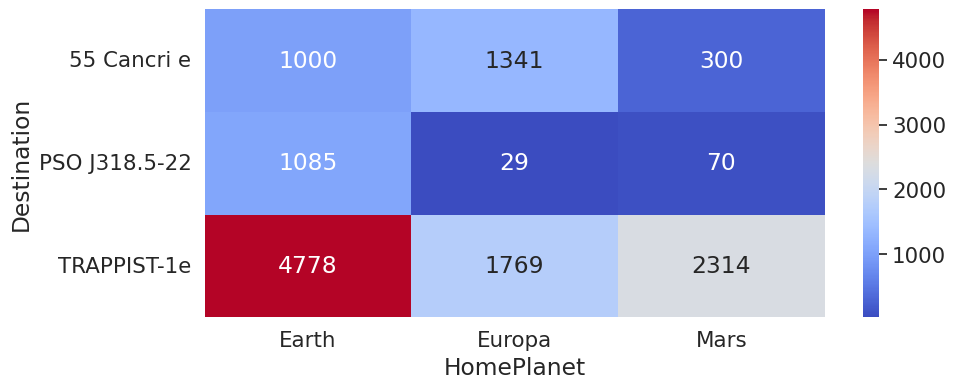

In [38]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

大多数前往TRAPPIST-1e的人来自地球，因此猜测他们来自那里是有道理的。但请记住之前提到的，没有人来自地球的D层甲板，所以我们需要将它们过滤掉。

In [39]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


运气不错，现在所有的母星的缺失值都补上了

**姓氏和所在的组**

先来看看姓是不是和之前有相同的规律每个姓都被分在一个组

In [58]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Cabin_side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Cabin_region7,Surname,Family_size
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,P,1,0,0,0,0,0,0,Ofracculy,3.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,S,1,0,0,0,0,0,0,Vines,4.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,S,1,0,0,0,0,0,0,Susent,7.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,S,1,0,0,0,0,0,0,Susent,7.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,S,1,0,0,0,0,0,0,Santantines,9.0


In [59]:
# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)


In [60]:
GSN_gb.head()

Surname,Acobson,Acobsond,Adavisons,Admingried,Aginge,Ailled,Aillyber,Ainatint,Aindlylid,Ainserfle,...,Woody,Wooes,Wooterston,Workmans,Workmanson,Wriggins,Yanton,Yatters,Yorkland,Youngrayes
Group,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
GSN_gb.shape

(2135, 1631)

In [61]:
# 查看GSB_gb中的数据不为0的值的个数
(GSN_gb>0).sum(axis=1).value_counts()

1    1769
2     322
3      43
4       1
dtype: int64

In [64]:
#统计每行不为0的个数
GSN_gb['count']=(GSN_gb>0).sum(axis=1)

In [67]:
GSN_gb.head()

Surname,Acobson,Acobsond,Adavisons,Admingried,Aginge,Ailled,Aillyber,Ainatint,Aindlylid,Ainserfle,...,Wooes,Wooterston,Workmans,Workmanson,Wriggins,Yanton,Yatters,Yorkland,Youngrayes,count
Group,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [69]:
GSN_gb['count'].value_counts()

2    1769
3     322
4      43
5       1
Name: count, dtype: int64

好像把行号那一列在统计的时候也算进去了，赶紧做个修正

In [73]:
#count列中所有的值-1
GSN_gb['count']=GSN_gb['count']-1

In [74]:
GSN_gb['count'].value_counts()

1    1769
2     322
3      43
4       1
Name: count, dtype: int64

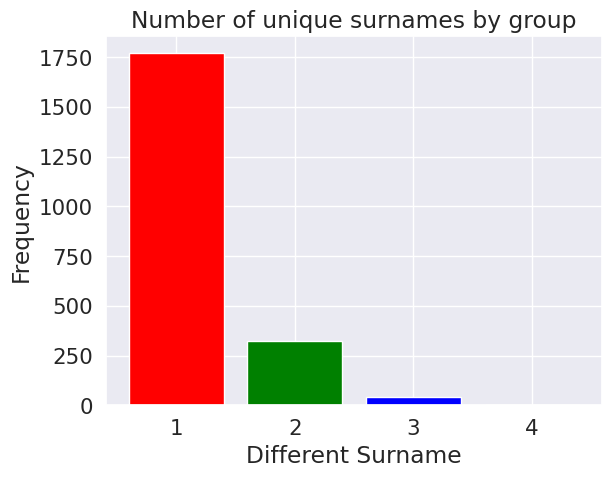

In [81]:
# sns一直出bug我自己手动画吧


x_values = [1, 2, 3, 4]
y_values = [1769, 322, 43, 1]
colors = ['red', 'green', 'blue', 'orange']

plt.bar(x_values, y_values, color=colors)
plt.xlabel('Different Surname')
plt.ylabel('Frequency')
plt.title('Number of unique surnames by group')

plt.show()


大多数（83%）的群组只包含一个家庭。因此，让我们根据该群组中的大多数姓氏来填充缺失的姓氏。

In [82]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())

#Surname missing values before: 294
#Surname missing values after: 155


这是我们能做的最好的处理方式了。我们不必去除所有这些缺失值，因为最终我们会删除姓氏特征。然而，我们可以更新家庭大小特征。

In [83]:
# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

**甲板位置和组号**

In [87]:
GCD_gb.head()

Cabin_deck,A,B,C,D,E,F,G,T
Group,,,,,,,,
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
20,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0


In [90]:
print(GCD_gb.index)

Int64Index([   3,    6,    8,   17,   20,   31,   32,   40,   44,   45,
            ...
            9220, 9227, 9231, 9238, 9252, 9266, 9267, 9272, 9275, 9280],
           dtype='int64', name='Group', length=2134)


In [91]:
# 重新设置索引
GCD_gb.reset_index(drop=True, inplace=True)

In [93]:
print(GCD_gb.index)

RangeIndex(start=0, stop=2134, step=1)


In [94]:
GCD_gb.head()

,A,B,C,D,E,F,G,T
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0


In [102]:
# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

In [103]:
GCD_gb['count']=(GCD_gb>0).sum(axis=1)

In [104]:
GCD_gb.head()

Cabin_deck,A,B,C,D,E,F,G,T,count
Group,,,,,,,,,
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
8,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1
17,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2
20,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1


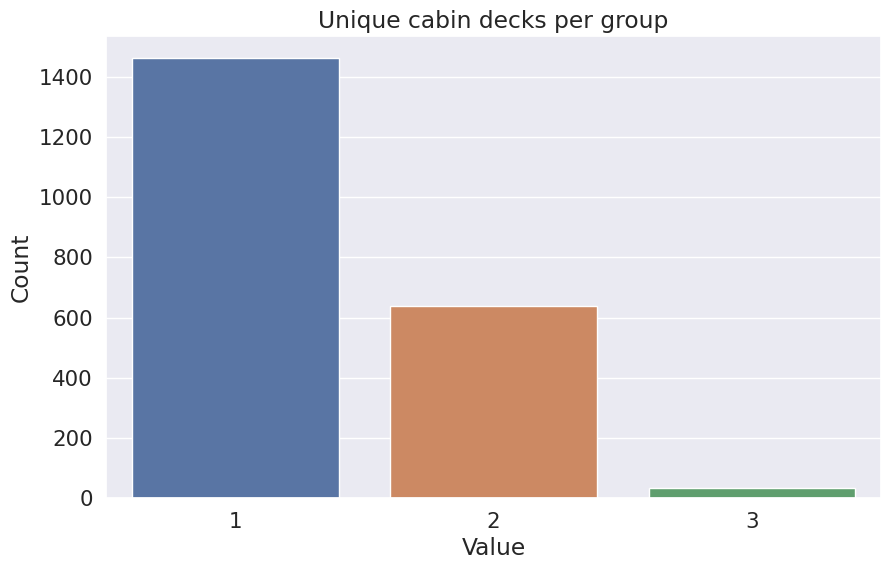

In [105]:
# 统计不同值的个数
value_counts = GCD_gb['count'].value_counts()

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Unique cabin decks per group')
plt.show()
